# Modeling and Simulation in Python

Chapter 11

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [5]:
!pip install pint
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

/bin/sh: pip: command not found


ModuleNotFoundError: No module named 'modsim'

In [4]:
init = State(S=5000, I=100, R=0)

NameError: name 'State' is not defined

To convert from number of people to fractions, we divide through by the total.

In [10]:
init /= sum(init)

NameError: name 'init' is not defined

`make_system` creates a `System` object with the given parameters.

In [185]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

Here's an example with hypothetical values for `beta` and `gamma`.

In [251]:
tc = 4      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

,values
init,S 0.988889 I 0.011111 R 0.000000 dtyp...
t0,0
t_end,98
beta,0.25
gamma,0.25


In [252]:
def add_hospitals(system, spending, percentage):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    z = percentage/100
    x = spending*z
    if spending <= 10000:
        affect = cube(x)
    else:
        affect = quad(x)

    new_gamma = system.beta * affect
    new_gamma += nurses(new_gamma)
    system.gamma = new_gamma/10

In [253]:
def sweep_money(hospital_array):
    sweep = SweepSeries()
    m = 1;
    
    counter = 0
    for fraction in hospital_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        counter += 1
        if counter == 1:
            print(results.I)

        
    return sweep

In [254]:
def nurses(probability):
    if flip(probability*10):
        return .1
    else:
        return 0

In [255]:
def cube(x):
    if 0<=x:return x**(1./4.)
    return -(-x)**(1./4.)

In [256]:
def quad(x):
    if 0<=x: return x**(1./4.)
    return -(-x)**(1./4.)

The update function takes the state during the current time step and returns the state during the next time step.

In [257]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state
    add_hospitals(system, 20000, t)
    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [258]:
state = update_func(init, 0, system)

,values
S,0.975586
I,0.024414
R,0.000000


In [259]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, t, system)
        
    return state

In [260]:
run_simulation(system, update_func)

,values
S,0.668091
I,0.000025
R,0.331884


In [261]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()

    state = system.init
    t0 = system.t0
    S[t0], I[t0], R[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        percentage = t
        state = update_func(state, t, system)
        S[t+1], I[t+1], R[t+1] = state
    
    return S, I, R 

Here's how we call it.

In [262]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
S, I, R= run_simulation(system, update_func)

And then we can plot the results.

In [263]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's what they look like.

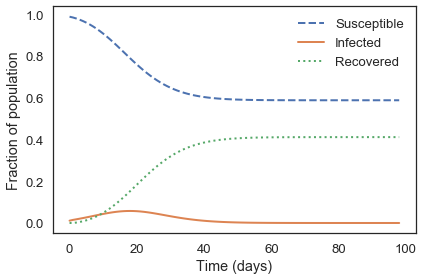

In [264]:
plot_results(S, I, R)


In [161]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

Here's how we run it, and what the result looks like.

In [162]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
results = run_simulation(system, update_func)
results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985226,0.014774,0.000000
2,0.980375,0.017626,0.002000
3,0.974615,0.020582,0.004803
4,0.967928,0.023667,0.008405


We can extract the results and plot them.

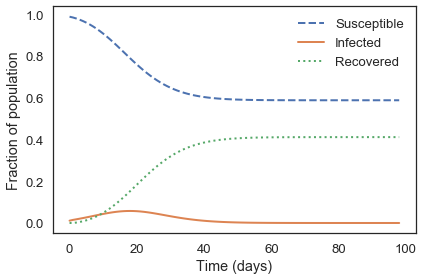

In [193]:
plot_results(results.S, results.I, results.R)

In [12]:
spending = 90000
hospital_array = linspace(0,95, 5)
plot(sweep_money(hospital_array))

NameError: name 'linspace' is not defined